# Exploratory data analysis and visualizations
## Faitelson tweets

Anyone that has been around Mexico's twitter football community is aware of the Faitelson phenomenon on this social network. When ever David Faitelson, one of the most popular sports commentators on the country, tweets about anything (from a football match to what he is having for lunch), that tweet will be filled with hundred of replies reminding him about a very specific event that occurred one hot evening in the Port of Veracruz...


>*Veracruz, March 8, 2003.* The air was thick with humidity and post-match tension. América had just beaten Veracruz 2–0 at the Luis "Pirata" Fuente Stadium, but the real knockout came off the pitch. As **David Faitelson**, the ever-provocative TV Azteca journalist, hovered near the locker rooms looking for an interview, a fist flew out of nowhere — ¡pum! — and landed square on his jaw.
>
>The puncher? None other than **Cuauhtémoc Blanco**, El Cuau, the streetwise genius from Tepito, freshly back from Europe and fed up with Faitelson’s relentless criticism. The blow came through a window that would echo through Mexican sports media for decades.
>
>The moment was caught on camera. Faitelson, stunned, clutched his face. The footage went viral before viral was even a thing. Memes were born. Jokes flew. And to this day, with every Faitelson tweet, Twitter lights up.
>


It is ironic that Faitelson's signature TV segment was called "El Color" because after this magnificent event users around Twitter have been looking for more colorful ways of reminding David what happened more than 22 years ago.

On December 20 of 2019 @DavidFaitelson_ tweeted:
![Tweet](./img/tweet1.png)

Here, for your delight, some of my favorite replies and their translations:
![Replies](./img/replies1.png)

Favorite reply:
> Expectations at the Jarocho Port were low since it was a lackluster Veracruz vs. América match. No one anticipated that the hunchbacked Commander would play his last card—and after sprinting toward the window, land that brutal blow that’s kept the crowd entertained ever since.


In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from parse_tweets import *

In [3]:
tweets = pd.read_csv("data/david_faitelson_tweets.csv",dtype={"tweet_id":"str"}).drop_duplicates(subset="tweet_id",keep="first").reset_index(drop=True)
replies = pd.read_csv("data/replies.csv",dtype={"tweet_id":"str","reply_id":"str"}).drop_duplicates(subset=["tweet_id",'text'],keep="first").loc[lambda x: x.tweet_id!=x.reply_id].reset_index(drop=True)

In [4]:
print(f"Total tweets: {tweets.shape[0]:,.0f}")
print(f"Total replies: {replies.shape[0]:,.0f}")

Total tweets: 3,974
Total replies: 89,697


In [5]:
tweets['date'] = tweets.text.map(get_date)
tweets['user'] = tweets.text.map(get_user)
tweets['tweet'] = tweets.text.map(format_text)

replies['date'] = replies.text.map(get_date)
replies['user'] = replies.text.map(get_user)
replies['tweet'] = replies.text.map(format_text)

In [6]:
replies['tweet_date'] = replies.tweet_id.map(tweets.set_index("tweet_id").date)

In [7]:
print(f"Avg replies per tweet: {replies.shape[0]/tweets.shape[0]:,.1f}")

Avg replies per tweet: 22.6


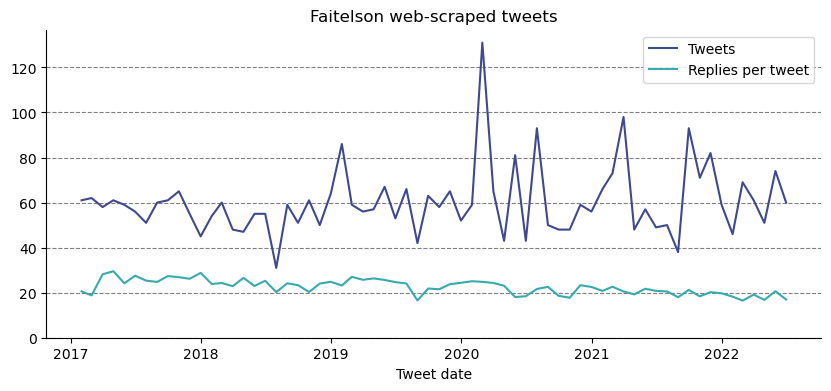

In [8]:
monthly_tweets = tweets.groupby(pd.Grouper(key="date",freq="ME")).size().to_frame("tweets")
monthly_replies = replies.groupby(pd.Grouper(key="tweet_date",freq="ME")).size().to_frame("replies")
monthly = pd.concat([monthly_tweets,monthly_replies],axis=1).assign(replies_per_tweet=lambda x: x.replies/x.tweets)

palette = sns.color_palette("mako",2)

fig,ax = plt.subplots(figsize=(10,4))
ax.plot(monthly.index,monthly.tweets,label="Tweets",c =palette[0])
ax.plot( monthly.index,monthly.replies_per_tweet,label="Replies per tweet",c=palette[1])
ax.spines[['top','right']].set_visible(False)
ax.grid(True,axis='y',c="grey",ls="--")
ax.set_title("Faitelson web-scraped tweets")
ax.set_xlabel("Tweet date")
ax.set_ylim(ymin=0)
ax.legend();

Being both datasets non exhaustive, not much conclusions can be drawn from the frequency and amount of tweets and replies.

What we can say is that the monthly amount of tweets and the number of replies per tweet looks consistent enough to say that we have a representative sample of replies to Faitelson tweets from 2017 to 2021.

### Replies of interest

Now, we are not looking for all of the replies to Faitelson's tweets. We are just interested in the ones that remind him of that whack to the cheeks.

To find replies about this glorious event we will look at the most common words of the replies and curate a list of words that must be present in a reply to be considered part of our final dataset.

For example, replies containing the words "Cuauhtemoc", "Veracruz" and "putazo" (slang for sucker punch) are likely replies that want to troll Faitelson.

In [9]:
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')

# Get Spanish stop words as a list
spanish_stopwords = stopwords.words('spanish')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\L781054\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
vectorizer = CountVectorizer(stop_words=spanish_stopwords)
X = vectorizer.fit_transform(replies['tweet'])


bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())


In [11]:
word_counts = bow_df.sum().sort_values(ascending=False)

word_counts.head(50)

si           8528
putazo       4001
tarde        3840
aquella      3826
mejor        3748
tepito       3634
david        3400
puerto       2961
solo         2871
equipo       2828
así          2561
faitelson    2508
veracruz     2492
siempre      2469
bien         2361
ser          2356
fútbol       2283
después      2197
américa      2144
dio          2101
tremendo     2005
hace         1999
chivas       1983
va           1973
aquel        1939
ahora        1911
morelos      1860
gran         1817
ver          1812
papada       1811
méxico       1797
mas          1766
vergazo      1721
pirata       1697
años         1696
liga         1619
gif          1583
divo         1560
jorobado     1550
jarocho      1491
madrazo      1484
partido      1473
tan          1468
fuente       1468
jugadores    1468
mexicano     1466
pues         1418
hoy          1418
cuau         1346
messi        1323
dtype: int64

Curated list of key words:

In [12]:
key_words_by_subject = {
    "punch":
        ['putazo','vergazo','madrazo','chingadazo','puño',"tortazo","sopla","moco",'gancho','golpe'],
    "cuauhtemoc":
        ['tepito','joroba','divo','cuau','cuauhtemoc','blanco','cuernavaca','dromedario','camello','cuello','white',"morelos","tlatoani",'emperador'],
    "time_and_location":
        ['veracruz','vera','tarde','puerto','pirata',"ventana","vestidor","jarocho","jarocha","2003",'heroico'],
    "recipient":
        ['papada','cachete','mandibula','quijada']
}

In [13]:
key_words = [x.lower()
 for sublist in key_words_by_subject.values()
 for x in sublist]

len(key_words)

39

In [14]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

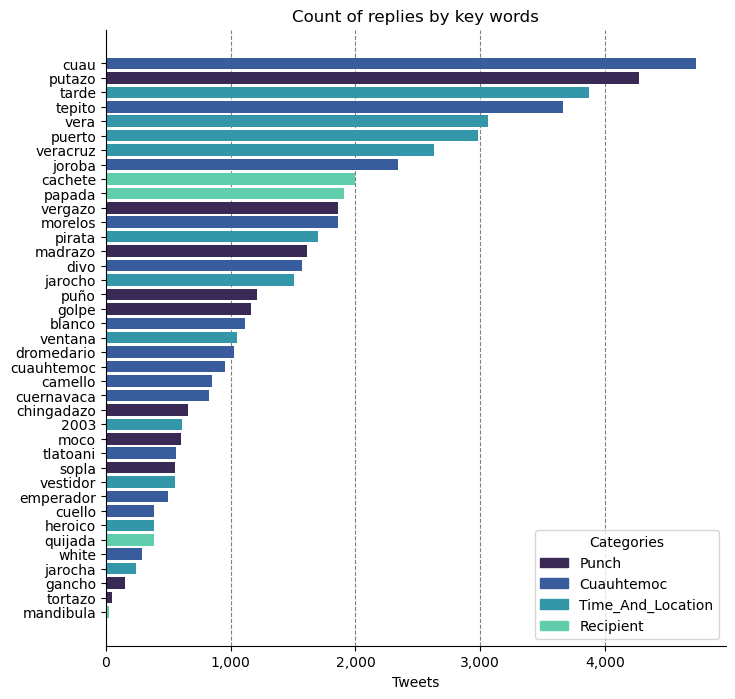

In [15]:
key_words_palette = sns.color_palette("mako",len(key_words_by_subject.keys()))
key_words_color = {}
key_words_count = {}
for w in key_words:
    c = replies[replies.tweet.str.lower().str.contains(w)].shape[0]
    key_words_count[w] = c
    key_words_color[w] = key_words_palette[[w in words for words in  key_words_by_subject.values()].index(True)]
key_words_count = dict(sorted(key_words_count.items(), key=lambda item: item[1]))



fig,ax=plt.subplots(figsize=(8,8))
y = np.arange(len(key_words_count))
ax.barh(y,key_words_count.values(),color=[key_words_color[w] for w in key_words_count.keys()],zorder=2)
ax.set_yticks(y)
ax.set_yticklabels(key_words_count.keys())

ax.spines[['top','right']].set_visible(False)
ax.grid(True,axis='x',c="grey",ls="--")
ax.set_title("Count of replies by key words")
ax.set_xlabel("Tweets")
ax.set_xlim(xmin=0)
ax.xaxis.set_major_formatter(lambda x,_: f"{x:,.0f}")

custom_handles = [ Patch(color=key_words_palette[i]) for i,k in enumerate(key_words_by_subject.keys())]
custom_label = [x.title() for x in key_words_by_subject.keys()]


ax.legend(custom_handles,custom_label,title="Categories");

The replies of interest will be those that contains at least one of the wey words.

In [16]:
replies['keep'] = replies['tweet'].str.lower().apply(lambda txt: any(word in txt for word in key_words))

In [17]:
print(f"Total replies of interest: {replies.keep.sum():,.0f}")
print(f"Percentage of replies of interest: {replies.keep.sum()/replies.shape[0]:.1%}")

Total replies of interest: 22,232
Percentage of replies of interest: 24.8%


In [18]:
used_tweets = replies[replies.keep].tweet_id.unique()
len(used_tweets),tweets.tweet_id.nunique()

(3582, 3974)

In [19]:
df = tweets[tweets.tweet_id.isin(used_tweets)].merge(replies[replies.keep].drop(["tweet_date",'keep'],axis=1),on="tweet_id",how="left")
# df['tweet_x']=df['tweet_x']+"\nRespuesta graciosa:"
print(df.shape)
assert df.tweet_id.nunique()==len(used_tweets)
df.to_csv("training_set.csv",index=False)
df.sample(10)

(22232, 10)


,tweet_id,text_x,date_x,user_x,tweet_x,reply_id,text_y,date_y,user_y,tweet_y
1874,972178840100499456,"David Faitelson\n@DavidFaitelson_\n·\nMar 9, 2...",2018-03-09,@DavidFaitelson_,"“¿400 millones por Neymar?. Por mi, pagaron 72...",972235941145346049,"gerardo\n@gerardo1508\n·\nMar 9, 2018\n400 mil...",2018-03-09,@gerardo1508,400 millones de personas son las que se deben ...
471,949004273110495232,"David Faitelson\n@DavidFaitelson_\n·\nJan 4, 2...",2018-01-04,@DavidFaitelson_,Hay que “felicitar” al América. Según “Scoccer...,949006029248913408,"DANIEL ALBERTO\n@Dalschefcdmx\n·\nJan 4, 2018\...",2018-01-04,@Dalschefcdmx,No tan grande como el putazo que te dio el mej...
4293,1043988565393235968,"David Faitelson\n@DavidFaitelson_\n·\nSep 23, ...",2018-09-23,@DavidFaitelson_,Uno de los mejores golfistas de la historia re...,1043988807266324480,"Víctor A. Cárdenas\n@vcardenas77\n·\nSep 23, 2...",2018-09-23,@vcardenas77,Tu deberías recuperar la memoria y acordarte d...
3384,1011636161314459648,"David Faitelson\n@DavidFaitelson_\n·\nJun 26, ...",2018-06-26,@DavidFaitelson_,Francia sigue sin mostrar su verdadero potenci...,1011650543100428288,"Dave with an E\n@DavidRoru10\n·\nJun 26, 2018\...",2018-06-26,@DavidRoru10,Peligroso el tremendo manotazo que te brindo e...
10888,1088336994466439169,"David Faitelson\n@DavidFaitelson_\n·\nJan 24, ...",2019-01-24,@DavidFaitelson_,"Mantenerse al margen de la injusticia, el desp...",1088656637332676608,Profesor Chairo de Chairos\n@ProfesorChairo\n·...,2019-01-24,@ProfesorChairo,Cállese o le mando a\n@cuauhtemocb10\na que lo...
8781,1235474459580084225,"David Faitelson\n@DavidFaitelson_\n·\nMar 5, 2...",2020-03-05,@DavidFaitelson_,"Talento le sobra, pero...\nCarlos Vela: Querer...",1235476147976024064,"Huguin\n@huguinconhashe\n·\nMar 5, 2020\nTalen...",2020-03-05,@huguinconhashe,"Talento le sobra, pero... él no te ha acomodad..."
18728,1076356026079891456,"David Faitelson\n@DavidFaitelson_\n·\nDec 21, ...",2018-12-21,@DavidFaitelson_,Termina un ciclo y comienza otro. Así es la vi...,1076526717118894081,"Ochavez\n@Oscar5Mexico\n·\nDec 22, 2018\nA cóm...",2018-12-22,@Oscar5Mexico,A cómo chingan con el jorobado gobernador tite...
16139,940018860438286341,"David Faitelson\n@DavidFaitelson_\n·\nDec 10, ...",2017-12-10,@DavidFaitelson_,"Regresó\n@TigresOficial\nMerecía el empate, au...",940019077275414528,"૭მჩყ\n@chap_chapis\n·\nDec 10, 2017\nMerecido ...",2017-12-10,@chap_chapis,Merecido el madrazo que te dieron en tus cache...
18452,1069321125069377537,"David Faitelson\n@DavidFaitelson_\n·\nDec 2, 2...",2018-12-02,@DavidFaitelson_,El fracaso de Tigres es inobjetable. ¿La culpa...,1069329092711989250,"Iván Franco\n@IvanFranco18\n·\nDec 2, 2018\nPr...",2018-12-02,@IvanFranco18,Profesional fue el vergaso que te metió\n@cuau...
15446,922490380116832256,"David Faitelson\n@DavidFaitelson_\n·\nOct 23, ...",2017-10-23,@DavidFaitelson_,"El fantástico Cristiano Ronaldo que sin ser ""T...",922496229325520896,"Chris Jones\n@elchrisjones\n·\nOct 23, 2017\nF...",2017-10-23,@elchrisjones,"Fantástico mi alcalde, que sin ser cirujano pl..."


Around a quarter of all the replies web-scrapped are used to remind Faitelson of what happened that day in Veracruz. Now it is clear why he is fed up with this trend.

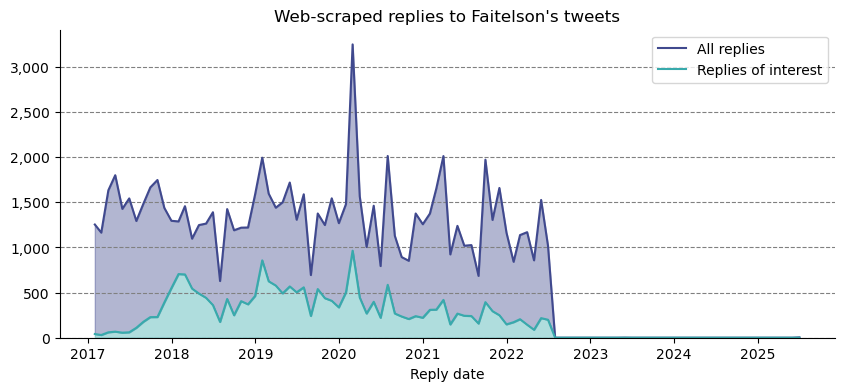

In [20]:
all_replies = replies.groupby(pd.Grouper(key="date",freq="ME")).size().to_frame("all")
cuau_replies = replies[replies.keep].groupby(pd.Grouper(key="date",freq="ME")).size().to_frame("cuau")
monthly = pd.concat([all_replies,cuau_replies],axis=1).fillna(0)

fig,ax = plt.subplots(figsize=(10,4))
ax.plot(monthly.index,monthly['all'],label="All replies",c =palette[0],zorder=2)
ax.fill_between(monthly.index,monthly['all'],monthly.cuau,color=palette[0],alpha=0.4)
ax.plot( monthly.index,monthly.cuau,label="Replies of interest",c=palette[1],zorder=2)
ax.spines[['top','right']].set_visible(False)
ax.fill_between(monthly.index,monthly['cuau'],0,color=palette[1],alpha=0.4)
ax.grid(True,axis='y',c="grey",ls="--")
ax.set_title("Web-scraped replies to Faitelson's tweets")
ax.set_xlabel("Reply date")
ax.set_ylim(ymin=0)
ax.yaxis.set_major_formatter(lambda x,_: f"{x:,.0f}")
ax.legend();

Again, our dataset is not exhaustive. But we can see that the trend of tweeting about the incident with Cuauhtémoc starts in the second half of 2017, hitting its highest point in 2019, and slowing down since then.

It has almost died out, but some users in 2025 are still going back to those old tweets to make snarky replies

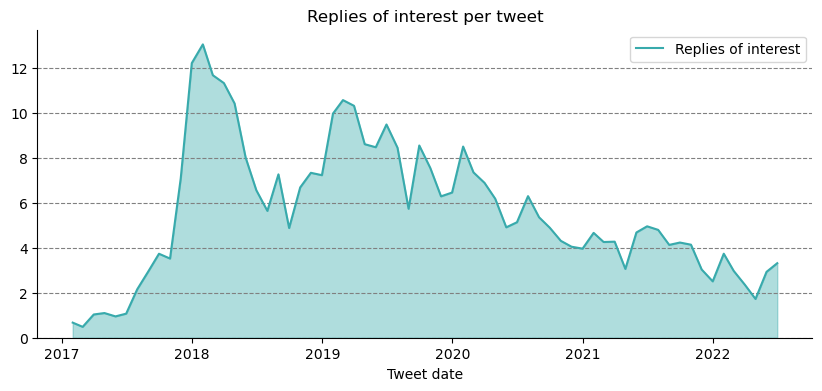

In [21]:
cuau_replies = replies[replies.keep].groupby(pd.Grouper(key="tweet_date",freq="ME")).size().to_frame("cuau")
all_tweets = tweets.groupby(pd.Grouper(key="date",freq="ME")).size().to_frame("tweets")
monthly = pd.concat([all_tweets,cuau_replies],axis=1).fillna(0).assign(interest=lambda x: x.cuau/x.tweets)

fig,ax = plt.subplots(figsize=(10,4))
ax.plot( monthly.index,monthly.interest,label="Replies of interest",c=palette[1],zorder=2)
ax.fill_between(monthly.index,monthly['interest'],0,color=palette[1],alpha=0.4)
ax.spines[['top','right']].set_visible(False)
ax.grid(True,axis='y',c="grey",ls="--")
ax.set_title("Replies of interest per tweet")
ax.set_xlabel("Tweet date")
ax.set_ylim(ymin=0)
ax.yaxis.set_major_formatter(lambda x,_: f"{x:,.0f}")
ax.legend();

It is no coincidence that, like the football phenomenon born in the rough neighborhood of Tepito, the previous chart has the shape of a hump. Just as Cuauhtémoc's back, the number replies of interest per tweet suffer a sudden increase, to then decrease slowly.

We can compare the length of the replies, to test if users talking about the sucker punch tend to be more expressive than "normal" replies.

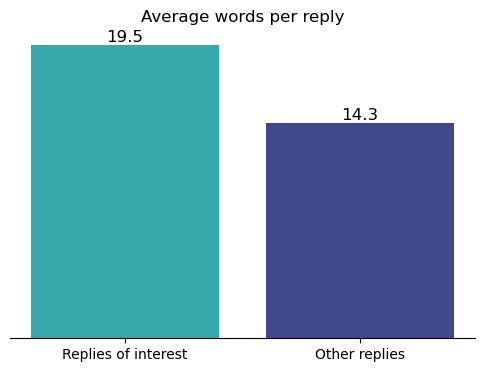

In [22]:
fig,ax =plt.subplots(figsize=(6,4))
replies_len = replies.assign(keep=lambda x: (~x.keep).astype(int)).assign(length=lambda x: x.tweet.str.split().str.len()).groupby('keep').length.mean()
# replies_len.sort_index(inplace=True,ascending=False)

ax.bar(replies_len.index,replies_len,color=palette[::-1])
ax.spines[['left','top','right']].set_visible(False)
ax.set_xticks(replies_len.index)
ax.set_yticks([])
ax.set_xticklabels(['Replies of interest','Other replies'])

for i,v in replies_len.items():
    ax.annotate(f"{v:,.1f}",xy=(i,v),va="bottom",ha="center",fontsize=12)

ax.set_title("Average words per reply");

In [23]:
print(f"Replies of interest exceed the length of other replies by {replies_len[0] - replies_len[1]:,.1f} words")

Replies of interest exceed the length of other replies by 5.2 words


Following Faitelson's convoluted style displayed in "El Color", trolls in Twitter make an effort to embellish their replies with longer, and hopefully funnier, tweets.

In [24]:
tweets_len = tweets.assign(length=lambda x: x.tweet.str.split().str.len()).groupby(pd.Grouper(key="date",freq="YE")).length.mean()
replies_len = replies[replies.keep].assign(length=lambda x: x.tweet.str.split().str.len()).groupby(pd.Grouper(key="tweet_date",freq="YE")).length.mean()

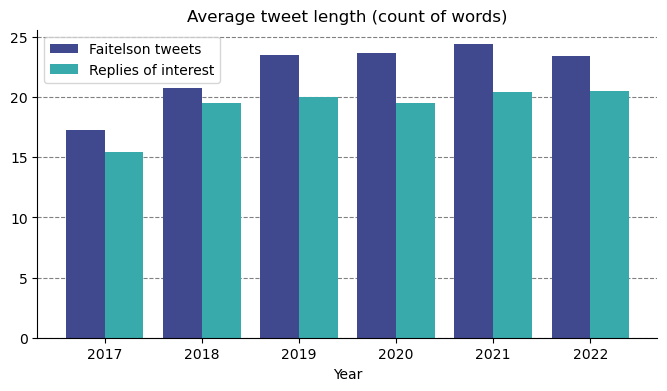

In [25]:
fig,ax =plt.subplots(figsize=(8,4))
x_labels = list(tweets_len.index.year)
x = np.arange(len(x_labels))

w_=0.4
ax.bar(x-(w_/2),tweets_len,width=w_,color=palette[0],label="Faitelson tweets",zorder=2)
ax.bar(x+(w_/2),replies_len,width=w_,color=palette[1],label="Replies of interest",zorder=2)

ax.set_xticks(x)
ax.set_xticklabels(x_labels)

ax.spines[['top','right']].set_visible(False)
ax.grid(True,axis='y',c="grey",ls="--",zorder=1)
ax.set_title("Average tweet length (count of words)")
ax.set_xlabel("Year")
ax.set_ylim(ymin=0)
ax.legend();



Faitelson's tweets length has gone up through the years. Through this time, Faitelson has engaged more and more with its community and he has taken advantage of this "trend" (insulting replies reminding him of what happened that evening in Veracruz). By having longer tweets, he gives his trolls more "meat" to play with

On the other hand, since the trolling began, replies length look consistent (2018-2021) at around 20 words per tweet. In the last year of data, replies average length hit is maximum at 21.2 words. For this last year we have fewer replies of interest, but those that stuck with the trend put more of an effort on their replies.

Being myself a Faitelson Twitter follower through the years, I have notices two strategies to increase trolls engagement in the platform:

1. Ending tweets with "...". This is like saying "Go on... I'm expecting your funny replies bellow"
2. Putting a word or more between quote marks. Followers will then use this words in a creative way to talk about what happened in that locker room. For example, if Faitelson writes ***"Amazing"*** *goal by Chicharito"*, replies will be on the form of *What really was **"amazing"** was your ability to keep standing up after such a whack*

Lets test this "hypothesis"...

In [26]:
tweets["has_quote_marks"] = tweets.tweet.str.contains("\"") | tweets.tweet.str.contains("\'")
tweets['has_ending_dots'] = tweets.tweet.str[-3:]=="..."

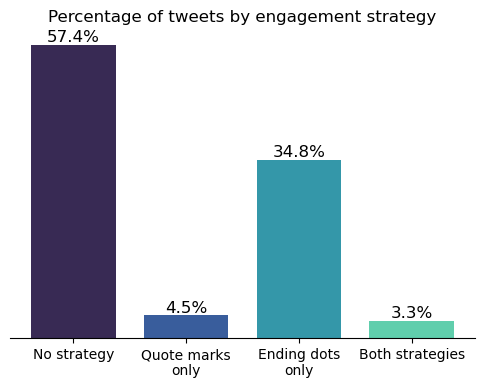

In [27]:
fig,ax=plt.subplots(figsize=(6,4))
strategy_palette = sns.color_palette("mako",4)
all_tweets =tweets.shape[0]
b1=ax.bar(0,tweets[~tweets.has_quote_marks & ~tweets.has_ending_dots].shape[0]/all_tweets,color=strategy_palette[0],width=0.75)
b2=ax.bar(1,tweets[tweets.has_quote_marks & ~tweets.has_ending_dots].shape[0]/all_tweets,color=strategy_palette[1],width=0.75)
b3=ax.bar(2,tweets[~tweets.has_quote_marks & tweets.has_ending_dots].shape[0]/all_tweets,color=strategy_palette[2],width=0.75)
b4=ax.bar(3,tweets[tweets.has_quote_marks & tweets.has_ending_dots].shape[0]/all_tweets,color=strategy_palette[3],width=0.75)


ax.spines[['left','top','right']].set_visible(False)
ax.set_xticks(np.arange(4))
ax.set_yticks([])
ax.set_xticklabels(['No strategy','Quote marks\nonly','Ending dots\nonly','Both strategies'])
bars = b1+b2+b3+b4
heights = [bar.get_height() for bar in bars]
for i,v in enumerate(heights):
    ax.annotate(f"{v:,.1%}",xy=(i,v),va="bottom",ha="center",fontsize=12)

ax.set_title("Percentage of tweets by engagement strategy");

Most tweets don't use a strategy at all. Let see if this changes through time.

Text(0.5, 1.0, "% of Faitelson's tweets using ending dots")

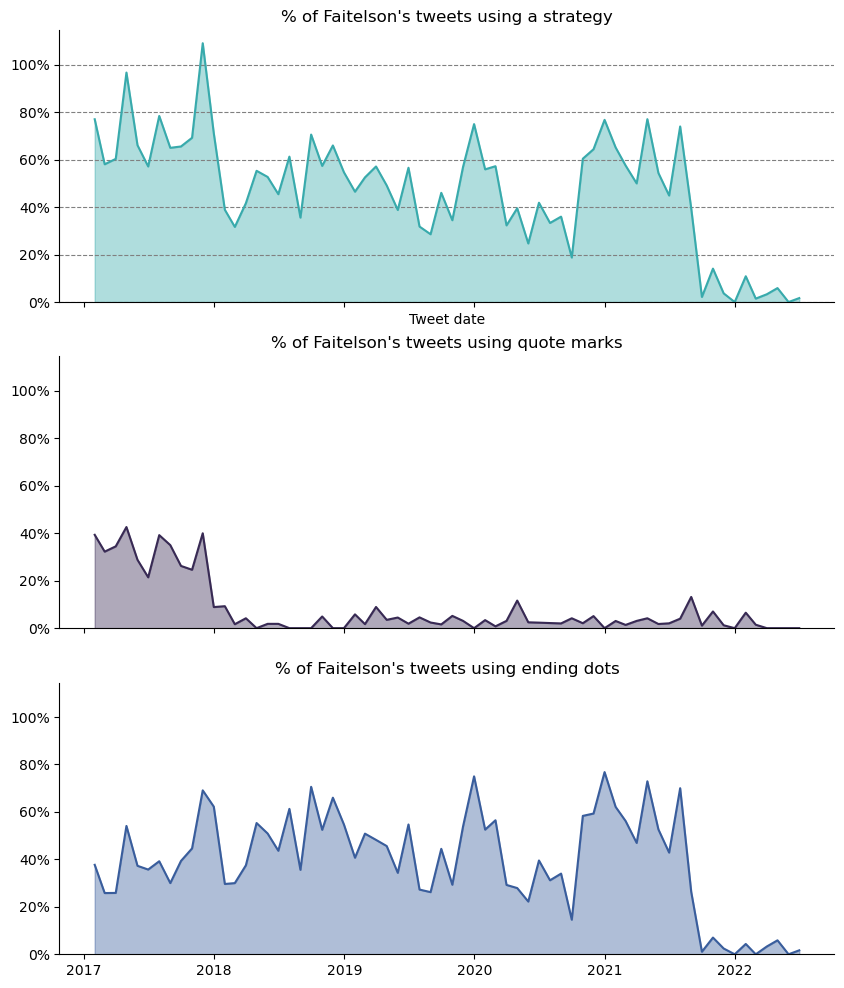

In [28]:
monthly = tweets.groupby(pd.Grouper(key='date',freq='ME'))[
    ['has_quote_marks','has_ending_dots']].sum()
all_tweets = tweets.groupby(pd.Grouper(key='date',freq='ME')).size().to_frame("all")
monthly = pd.concat([monthly,all_tweets],axis=1).fillna(0).assign(uses_strategy=lambda x: (x.has_ending_dots+x.has_quote_marks)/x['all']).assign(
    uses_quotes=lambda x: x.has_quote_marks/x['all']
).assign(uses_dots=lambda x: x.has_ending_dots/x['all'])

fig,axs = plt.subplots(3,1,figsize=(10,12),sharex=True,sharey=True)

ax=axs[0]
ax.plot(monthly.index,monthly['uses_strategy'],c =palette[1],zorder=2)
ax.fill_between(monthly.index,monthly['uses_strategy'],0,color=palette[1],alpha=0.4)
ax.spines[['top','right']].set_visible(False)
ax.grid(True,axis='y',c="grey",ls="--")
ax.set_title("% of Faitelson's tweets using a strategy")
ax.set_xlabel("Tweet date")
ax.set_ylim(ymin=0)
ax.yaxis.set_major_formatter(lambda x,_: f"{x:,.0%}");

ax=axs[1]
ax.plot(monthly.index,monthly['uses_quotes'],c =strategy_palette[0],zorder=2)
ax.fill_between(monthly.index,monthly['uses_quotes'],0,color=strategy_palette[0],alpha=0.4)
ax.spines[['top','right']].set_visible(False)
ax.set_title("% of Faitelson's tweets using quote marks")

ax=axs[2]
ax.plot(monthly.index,monthly['uses_dots'],c =strategy_palette[1],zorder=2)
ax.fill_between(monthly.index,monthly['uses_dots'],0,color=strategy_palette[1],alpha=0.4)
ax.spines[['top','right']].set_visible(False)
ax.set_title("% of Faitelson's tweets using ending dots")

It doesn't look like Faitelson intentionally increased the usage of one of these strategies to boost engagement.

On the contrary, it looks like using quote marks was something he did before trolling began, an then he stopped using them in 2018 when he realized what was going on under his tweets.

Nevertheless, we can still check if tweets with either of this strategies increase the number of replies of interest:

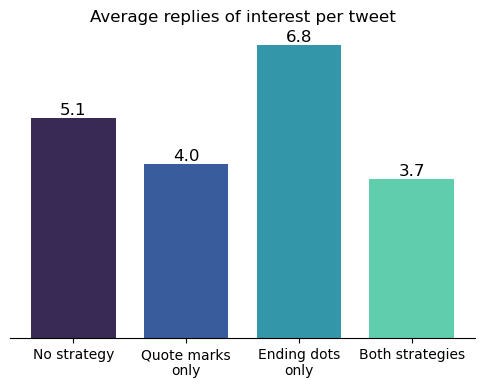

In [29]:
fig,ax=plt.subplots(figsize=(6,4))
strategy_palette = sns.color_palette("mako",4)
all_tweets =tweets.shape[0]
no_strategy = tweets[~tweets.has_quote_marks & ~tweets.has_ending_dots].tweet_id
b1=ax.bar(0,replies[replies.keep & replies.tweet_id.isin(no_strategy)].shape[0]/len(no_strategy),color=strategy_palette[0],width=0.75)
quotes_strategy = tweets[tweets.has_quote_marks & ~tweets.has_ending_dots].tweet_id
b2=ax.bar(1,replies[replies.keep & replies.tweet_id.isin(quotes_strategy)].shape[0]/len(quotes_strategy),color=strategy_palette[1],width=0.75)
dots_strategy = tweets[~tweets.has_quote_marks & tweets.has_ending_dots].tweet_id
b3=ax.bar(2,replies[replies.keep & replies.tweet_id.isin(dots_strategy)].shape[0]/len(dots_strategy),color=strategy_palette[2],width=0.75)
both_strategy = tweets[tweets.has_quote_marks & tweets.has_ending_dots].tweet_id
b4=ax.bar(3,replies[replies.keep & replies.tweet_id.isin(both_strategy)].shape[0]/len(both_strategy),color=strategy_palette[3],width=0.75)


ax.spines[['left','top','right']].set_visible(False)
ax.set_xticks(np.arange(4))
ax.set_yticks([])
ax.set_xticklabels(['No strategy','Quote marks\nonly','Ending dots\nonly','Both strategies'])
bars = b1+b2+b3+b4
heights = [bar.get_height() for bar in bars]
for i,v in enumerate(heights):
    ax.annotate(f"{v:,.1f}",xy=(i,v),va="bottom",ha="center",fontsize=12)

ax.set_title("Average replies of interest per tweet");

Again, no clear answer here. But it looks like using ending dots increased trolls appetite while using quote marks decreased it.

### Next step: Train the @Faitelbot

After this in-depth analysis of replies to Faitelson's tweets, the next step is to use the pairs of tweets and replies of interest to train a bot that will reply to every Faitelson tweet using the style of his trolls.

A moment as "epic" as the one occurred on March of 2003 is not to be forgotten. The Faitelbot is here to help with this important task...